#### Helper Methods

In [1]:
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt 

In [2]:
log = True
component_path = "./sector_components/"
pricing_path = "./pricing/"
date_fmt = '%m-%d-%Y'

#variable for data download
hist_window = 252*10 #used for downloading pricing
frame = (-252*3); #used for running optimizations
length = 252 # used in q&a and sanity checks
end_date_str = tgt_date_str = '1-18-2018'
start_date = datetime.strptime('1-18-2018', date_fmt) - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5

#variables for performance analysis
lookback = 20; frequency = "W-WED"
min_gross=1; max_gross=1; min_w=0; max_w=0.1

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE']
}

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
compound = lambda x: (x + 1).cumprod()
two_dec = lambda x: '%.3f' % x
def get_pricing(fname, ticker_list, start_date):
    if log: print("Getting pricing for:", fname, start_date)
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.sort_index(ascending=True, inplace=True)
    px.to_csv(pricing_path + fname)
    return px
def get_safe_pricing(fname, ticker_list, s_date):
    while True:
        try:
            ticker_list; get_pricing(fname, ticker_list, s_date); break
        except Exception as err:
            print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
            sleep(sleep_time)
def load_pricing(f, idx_col):
    fname = pricing_path + f
    px = pd.read_csv(fname, index_col=idx_col, parse_dates=True)
    px.sort_index(ascending=True, inplace=True)
    if log: print("Loaded pricing for {}, with shape {}".format(f, px.shape))
    return px
def download_components(etf, start_date):
    tickers = sector_tickers_map[etf] # for individual components
    get_pricing(etf + '-hold-pricing.csv', tickers, start_date)
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df

In [4]:
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values    
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum=1, max_sum=1, min_w=0, max_w=0.2):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    # removed the min_sum
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(cvx.abs(w)) <= max_sum,
         w > min_w,
         w < max_w])
    gamma.value = 50; prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]

In [5]:
p_template = "Ann. return: {0:.2f}%, std dev: {1:.2f}%, sharpe: {2:.2f}"
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)
def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]
def date_intervals(df, freq):
    #using pandas
    return df.resample(freq, closed='left', label='left').mean()
def portfolio_metrics(pdf):
    ret = (pdf.pct_change().mean() * 252).values[0]
    std = (pdf.pct_change().std() * sqrt(252)).values[0]
    if log: print(p_template.format(ret * 100, std * 100, ret / std))
    return ret, std, ret / std

In [6]:
def get_weights(px, freq, lb=20, min_sum=1, max_sum=1, min_w=0, max_w=0.1):
    px.dropna(axis=1, inplace=True)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    #cols = returns.columns    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    #if log: 
        #print("Empty allocations:", hist_alloc.shape)
        #print('{0:d} stocks, {1:d} days, {2:d} lookback'.format(len(returns.columns), len(px), lb))

    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum=min_sum, max_sum=max_sum, min_w=min_w, max_w=max_w)
        hist_alloc.loc[i.date()] = weights

    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    
    #if log: print("returns: days / stocks", returns.shape, "allocation: days / stocks", hist_alloc.shape)
    return returns, hist_alloc
def recommend_allocs(px, frame, lb, freq, min_gross=1, max_gross=1, min_w=0, max_w=0.1):
    cols = px.count().sort_values()[px.count().sort_values() < 1].index.tolist()
    px = px.drop(cols, axis=1)
    px_portion = px[frame:].copy() 
    px_portion.dropna(axis=1, inplace=True)
    returns, alloc = get_weights(
        px_portion, frequency, lb=lookback, max_sum=max_gross, min_w=min_w, max_w=max_w)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf            
# show top holdings and last recomended holding set
def selected_allocs(w, irange):
    w = w.loc[irange].sum(axis=0).sort_values(ascending=False)
    return w[w > 0]
def period_allocs(w, irange):
    w = (recomend_allocs(w, irange) / max_w).astype(np.int)
    return w

#### Load sector components from hard-drive

In [67]:
# load sector components
colstoload = ['Symbol','Company Name', 'Index Weight']
pattern = r'holdings-'
flist = os.listdir(component_path)
files = [f for f in flist if f.startswith(pattern)]
companies = pd.DataFrame([])

for s in sectors:
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
if log: 
    print("Company Sample:", companies.shape); 
    #print(companies.groupby('ETF')['Index Weight'].count())
    
px_etfs = load_pricing('sectors.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Company Sample: (505, 3)
Loaded pricing for sectors.csv, with shape (1738, 10)
Loaded pricing for SPY.csv, with shape (1738, 1)


In [75]:
companies.loc[['HP', 'LOW', 'ISRG']]['ETF'].tolist()

['XLE', 'XLY', 'XLV']

#### Get Data from the Server

In [8]:
#Downloads pricing on all components for each ETF
load_components(sectors, companies, colstoload, sector_tickers_map)
etfs = [e for e in sectors]
while len(etfs) > 0: 
    try:
        val = etfs[-1]; download_components(val, start_date); etfs.pop()
    except Exception as err:
        print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
        sleep(sleep_time)

Company Sample: (505, 3)
Getting pricing for: XLRE-hold-pricing.csv 02-24-2011


KeyboardInterrupt: 

In [80]:
get_safe_pricing('sectors.csv', sectors, start_date)
get_safe_pricing('SPY.csv', ['SPY'], start_date)

Getting pricing for: sectors.csv 02-24-2011
Getting pricing for: SPY.csv 02-24-2011


#### Generate Trading Recomendations

TODO List
1. Produce ETF level recomendation (sector weightings) DONE
2. Produce recomendations for each sector DONE
3. Calculate sharpe rankings for a given company list DONE
4. Show spread returns starting at different times for each sector
5. Create long / short optimizers
6. Test portofolio with both long and shorts

In [77]:
#Produce recomendations for each sector
#Another way to do this is to put all sector together and let the algo pick the best 20 positios
log = False
sum_cols = ["Alloc", "Ret", "Std", "Sharpe", "Sector"]
summary = pd.DataFrame([], columns=sum_cols)

for dwld_key in sectors:
    if log: print("Running optimization for:", dwld_key)
    # Load pricing for ETF and all its components
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
    spyder_etf = px_etfs[dwld_key].copy()
    # Run optimization for ETF Components
    px_portion, returns, alloc, pdf = recommend_allocs(px, frame, lookback, frequency, max_w=0.05)
    portfolio_metrics(pdf);
    # Show portfolio metrics for ETF
    portfolio_metrics(pd.DataFrame(spyder_etf, index=spyder_etf.index, columns=[dwld_key]));
    # List recomended positions per sector
    r = returns[-length:].astype(np.float16); w = alloc[-length:].astype(np.float16)
    irange = pd.to_datetime(date_intervals(r, frequency).index.tolist())[-1:]
    top = 10; rec = selected_allocs(alloc, irange)[:top]
    tickers = rec.index.tolist()
    sel_df = px[tickers][-lookback:].pct_change()
    sel_df_ret = sel_df.mean() * (252/lookback); sel_df_std = sel_df.std() * sqrt(lookback)
    sel_df_sharpe = sel_df_ret / sel_df_std
    vals = np.array(
        [rec.values, sel_df_ret.values, sel_df_std.values, sel_df_sharpe.values, [dwld_key] * top])
    sector_df = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
    summary = summary.append(sector_df)

summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']

In [94]:
#Another way to do this is to put all sector together and let the algo pick the best 20 positios
log = True
max_w=0.05
sum_cols = ["Alloc", "Ret", "Std", "Sharpe", "Sector"]
summary = pd.DataFrame([], columns=sum_cols)
consol_px = pd.DataFrame([])

for dwld_key in sectors:
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')[frame:].copy()
    consol_px = consol_px.merge(px, left_index=True, right_index=True, how='outer')
px_portion, returns, alloc, pdf = recommend_allocs(consol_px, frame, lookback, frequency, max_w)
portfolio_metrics(pdf);
portfolio_metrics(px_spy[frame:]);

Loaded pricing for XLE-hold-pricing.csv, with shape (1738, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (1738, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (1738, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (1738, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (1738, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (1738, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (1738, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (1738, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (1738, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (1738, 33)
Ann. return: 42.12%, std dev: 12.95%, sharpe: 3.25
Ann. return: 13.55%, std dev: 12.18%, sharpe: 1.11


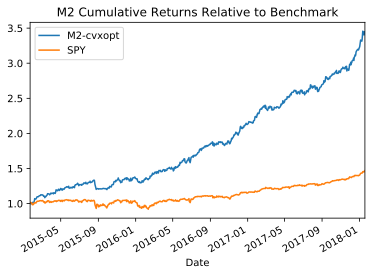

In [87]:
# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_spy = (px_spy[-len(pdf):].pct_change() + 1).cumprod()
s_spy.plot(ax=ax, legend='right');

In [93]:
# List recomended positions per sector
r = returns[-length:].astype(np.float16); w = alloc[-length:].astype(np.float16)
irange = pd.to_datetime(date_intervals(r, frequency).index.tolist())[-1:]
# selected top picks
top = int(1/max_w); rec = selected_allocs(alloc, irange)[:top]
tickers = rec.index.tolist()
# calculated key metrics for each stock
sel_df = px_portion[tickers][-lookback:].pct_change()
sel_df_ret = sel_df.mean() * (252/lookback); sel_df_std = sel_df.std() * sqrt(lookback)
sel_df_sharpe = sel_df_ret / sel_df_std
vals = np.array([
    rec.values, sel_df_ret.values, sel_df_std.values, 
    sel_df_sharpe.values, companies.loc[tickers]['ETF'].tolist()])
sector_df = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
summary = summary.append(sector_df)
summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']
summary

,Alloc,Ret,Sector,Sharpe,Spread,Std
SLB,1.000000e-01,0.106149,XLE,1.643295,0.041554,0.064595
ISRG,1.000000e-01,0.112426,XLV,1.264326,0.023504,0.088922
LOW,1.000000e-01,0.102326,XLY,1.471041,0.032766,0.069560
MRK,1.000000e-01,0.059898,XLV,0.891100,-0.007320,0.067218
HP,1.000000e-01,0.101530,XLE,1.665879,0.040583,0.060947
BA,1.000000e-01,0.085533,XLI,1.028388,0.002361,0.083171
APC,1.000000e-01,0.092963,XLE,1.281958,0.020447,0.072516
STX,6.418583e-02,0.160288,XLK,1.776636,0.070068,0.090220
TSCO,5.553653e-02,0.081405,XLY,1.766443,0.035321,0.046084
ILMN,4.988191e-02,0.080799,XLV,0.908767,-0.008112,0.088911


In [89]:
sum_gb = summary.groupby(by="Sector").mean()
cols_to_rank = ['Ret', 'Sharpe', 'Spread']
ranked_sectors = sum_gb[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
if log: 
    print("Mean recomendations grouped by by Sector")
    print(sum_gb.sort_values(by="Spread", ascending=False))
if log: 
    print("Sectors ranked from best to worst")
    print(ranked_sectors)

Mean recomendations grouped by by Sector
           Alloc       Ret       Std    Sharpe    Spread
Sector                                                  
XLY     0.051846  0.096185  0.063610  1.543893  0.032575
XLI     0.044207  0.085926  0.062294  1.477625  0.023632
XLE     0.053821  0.092365  0.069926  1.348333  0.022439
XLK     0.028406  0.091656  0.075175  1.151404  0.016480
XLV     0.062470  0.078636  0.072886  1.096321  0.005750
Sectors ranked from best to worst
Sector
XLY    1.000000
XLE    2.666667
XLI    2.666667
XLK    3.666667
XLV    5.000000
dtype: float64


In [20]:
ranked_cos = summary[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
top_picks = summary.loc[ranked_cos[:20].index]
if log: print("\nPortfolio Sector Allocations")
top_picks.groupby(by='Sector')['Alloc'].count() / len(top_picks)
if log: print("Top 20 companies ranked from best to worst\n")
top_picks

,Alloc,Ret,Std,Sharpe,Sector,Spread
SLB,0.05,0.149944,0.059120,2.536283,XLE,0.090824
ARNC,0.05,0.141200,0.056607,2.494395,XLI,0.084593
HP,0.05,0.143161,0.061189,2.339641,XLE,0.081972
HAL,0.05,0.120217,0.046573,2.581261,XLE,0.073644
TSCO,0.05,0.117953,0.054325,2.171234,XLY,0.063627
APC,0.05,0.140427,0.072484,1.937336,XLE,0.067942
CAT,0.05,0.101658,0.038048,2.671841,XLI,0.063610
TGT,0.05,0.145198,0.077885,1.864253,XLY,0.067313
ADS,0.05,0.104892,0.043459,2.413562,XLK,0.061433
MRO,0.05,0.148105,0.084444,1.753894,XLE,0.063662


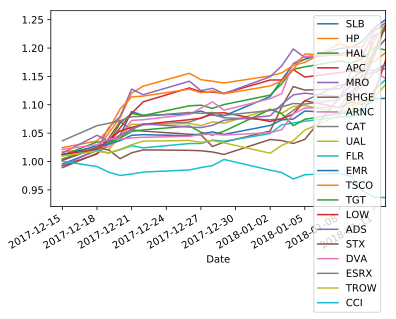

In [46]:
# want to plot the pricing for top picks
# 1) get sectors 2) find stocks in sector pricing 3) merge all dfs into one 4) plot all as index
sel_sectors = pd.unique(top_picks['Sector']) #1
consol_tp_px = pd.DataFrame([])
for s in sel_sectors:
    s_px = load_pricing(s + '-hold-pricing.csv', 'Date')[-lookback:].sort_index()
    s_tickers = top_picks[top_picks['Sector'] == s].index.tolist()
    s_df = s_px[s_tickers] #2
    consol_tp_px = consol_tp_px.merge(s_df, left_index=True, right_index=True, how='outer') #3
(consol_tp_px.pct_change() + 1).cumprod().plot()

#### Run Optimizations

Loaded pricing for sectors.csv, with shape (1738, 10)
Loaded pricing for SPY.csv, with shape (1738, 1)
Ann. return: 9.29%, std dev: 4.65%, sharpe: 2.00


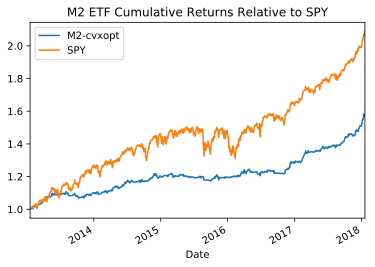

In [149]:
# Loads from hard drive pricing for components and corresponding sector
spyder_etf = px_etfs[dwld_key].copy()

#Produce ETF level recomendation (sector weightings)
etfs_px_portion, etfs_ret, etfs_alloc, etfs_pdf = recommend_allocs(
    px_etfs, frame, lookback, frequency, max_w=0.2)
portfolio_metrics(etfs_pdf)

s_spy = (px_spy[-len(etfs_px_portion):].pct_change() + 1).cumprod()
# Plot optimization vs. benchmark
ax = etfs_pdf.plot(title="M2 ETF Cumulative Returns Relative to SPY");
s_spy.plot(ax=ax, legend='right');

Loaded pricing for XLK-hold-pricing.csv, with shape (1738, 71)
Loaded pricing for sectors.csv, with shape (1738, 10)
Ann. return: 28.74%, std dev: 10.46%, sharpe: 2.75


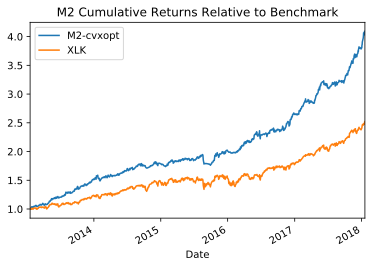

In [150]:
dwld_key = 'XLK'
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
px_etfs = load_pricing('sectors.csv', 'Date')
spyder_etf = px_etfs[dwld_key].copy()

# Run a sector specific optimization
px_portion, returns, alloc, pdf = recommend_allocs(
    px, frame, lookback, frequency, max_w=0.1)
portfolio_metrics(pdf);

s_etf = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
returns, alloc = get_weights(
    px_portion, frequency, lb=lookback, max_sum=max_gross, min_w=min_w, max_w=max_w)

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_etf.plot(ax=ax, legend='right');

In [ ]:
# Create Chart to show return spread vs. ETF for a given time window
# Conclusion: The shorter the holding gets the more likely to underperform
holding = 180; stop = int(len(alloc) - holding); jumps = 10
offsets = [x for x in range(0, stop, jumps)]

msg = "Portfolio metrics starting every {} trading days and holding for {} days"
print(msg.format(jumps, holding))

cols = ["M2", "Bechmark", "M2_Return", "M2_StdDev", "M2_Sharpe"]
results = pd.DataFrame([], index=offsets, columns=cols)
for o in offsets:
    start = np.min([o, len(alloc)-1])
    end = np.min([o+holding, len(alloc)])
    p = px_portion[start:end].copy()
    s_etf = (spyder_etf[-len(px_portion):][start:end].pct_change() + 1).prod()
    r, w = get_weights(p, "W-WED", max_w=0.10)
    port_perf = calc_port_performance(r.values, w.values)
    pdf = pd.DataFrame(port_perf, index=r.index) # index by date
    ret, std, sharpe = portfolio_metrics(pdf)
    results.loc[o, cols]= [pdf[-1:].values[0][0], s_etf, ret, std, sharpe]
chart_title = "Cumulative Return Starting every {} days for {}".format(jumps, dwld_key)
results[cols[0:2]].plot(title=chart_title)
under = results[results["M2"] < results["Bechmark"]][results.columns[0]].count()
print("Portfolio underperformed: {}% of the time".format(under/len(results)*100))

In [152]:
# show portfolio metrics for a given time window
log = True
length = 252
msg = "Portfolio metrics for the last {} days"
print(msg.format(length))
w = alloc[-length:].astype(np.float)
r = returns[-length:].astype(np.float)
port_perf = calc_port_performance(r.values, w.values)
pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics(pdf);

Portfolio metrics for the last 252 days
Ann. return: 43.66%, std dev: 9.97%, sharpe: 4.38


2013 1.5137
2014 1.1445
2015 1.1055
2016 1.2881
2017 1.4062


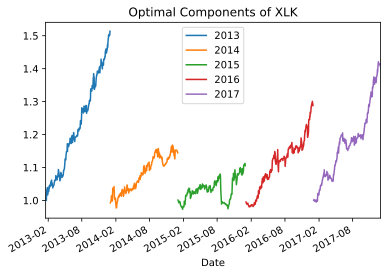

In [153]:
# plot portfolio performance by year
first_year = int(alloc.index[0].year)
last_year = int(alloc.index[-1].year)
years = [y for y in range(first_year, last_year, 1)] 

def perf_by_years(r, a, years):
    ax = plt.axes()
    for y in years:
        year = str(y)
        w = alloc.loc[year].astype(np.float16)
        r = returns.loc[year].astype(np.float16)
        p_perf = calc_port_performance(r.values, w.values)
        result = pd.DataFrame(p_perf, index=w.index, columns=[year])
        result.plot(title='Optimal Components of ' + dwld_key, ax=ax, legend='right')
        if log: print(year, result[-1:].values[0][0])

perf_by_years(returns, alloc, years)

In [154]:
w = alloc[-length:].astype(np.float16)
intervals = pd.to_datetime(date_intervals(r, frequency).index.tolist())

top = 5
irange = intervals
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

irange = intervals[-5:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

irange = intervals[-1:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

Top 5 holdings during the last 53 intervals
TSS     2.169922
STX     1.346680
DXC     1.309570
AAPL    1.282227
EBAY    1.269531
dtype: float16
Top 5 holdings during the last 5 intervals
TXN    0.500000
TSS    0.500000
STX    0.321289
ACN    0.299805
V      0.299805
dtype: float16
Top 5 holdings during the last 1 intervals
HPQ    0.099976
ADI    0.099976
IBM    0.099976
V      0.099976
TXN    0.099976
dtype: float16


#### Sensitivities

In [ ]:
lbs = [x for x in range(5, 15, 5)]
mws = (np.array([x for x in range(4, 24, 4)]) / 100).tolist()
for i, l in enumerate(lbs):
    for j, w in enumerate(mws):
        print(l, w)

In [ ]:
def create_matrix(px, start, end, step):
    print("Creating Sensitivity Matrix...")
    lbs = [x for x in range(start, end, step)]
    mws = (np.array([x for x in range(start, end, step)]) / 100).tolist()
    df = pd.DataFrame([], index=mws, columns=lbs)
    df.index.name = "Max Exposure"
    df.columns.name = "Lookback"
    
    for i, l in enumerate(lbs):
        for j, w in enumerate(mws):
            r, w = get_weights(px_portion, freq, lb=l, max_w=w)
            port_perf = calc_port_performance(r.values, w.values)
            pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
            days = len(pdf)
            ret, std, sharpe = portfolio_metrics(pdf);
            df.iloc[i, j] = (
                ret.astype(np.float16), 
                std.astype(np.float16), 
                sharpe.astype(np.float16))
    print("Complete")
    return df
def heatmap(df, cmap = plt.cm.inferno): 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels( list(df.index))
    plt.colorbar(axim)

In [ ]:
sm = create_matrix(px, 10, 20, 5)

In [ ]:
curr = 2
m_list = ["Return", "StdDev", "Sharpe"]
print("Showing:", m_list[curr])
extract = lambda x: x[curr]
df = sm.applymap(extract)
heatmap(df.astype(float), cmap = plt.cm.gray_r)

In [ ]:
sm

#### Old Cells

In [ ]:
vals = np.arange(9).reshape(3, 3)
vals
m2 = np.array([vals[0], vals[1], vals[2]])
m2
matrix = pd.DataFrame(m2, index=['1','2','3'], columns=['A','B','C'])
#matrix[matrix.columns] = vals
matrix
[dwld_key] * 10

In [ ]:
# Downloads pricing from yahoo for components + sector ETF
tickers = sector_tickers_map[dwld_key] # for individual components
#tickers = ticker_map["sectors"] # for individual ETFs
px = get_pricing(dwld_key + '-hold-pricing.csv', tickers, start_date.strftime(date_fmt))
etf = get_pricing(dwld_key + '.csv', dwld_key, start_date.strftime(date_fmt))
spyder_etf = pd.DataFrame(etf)
spyder_etf.index.name = "Date"
spyder_etf.columns=[dwld_key]
spyder_etf.to_csv(dwld_key + '.csv')

In [ ]:
#CHECK compounding math
#what were the top 10 allocations tickers?
top_stocks = alloc.sum(axis=0).sort_values(ascending=False)[:10].index.tolist()
# what was their allocation?
alloc = alloc[top_stocks]
# how much did we allocate to them?
cum_alloc = alloc.sum(axis=1)
# multiply the daily returns of top allocations times our allocation
port_return = (returns[top_stocks] * alloc).sum(axis=1)
# we add 1 to get the compounding index
port_index = (port_return + 1).cumprod()
#cumulative return for the portfolio
print(port_index[-1:], len(port_index), "days")

port_perf = calc_port_performance(returns[top_stocks].values, alloc.values)
print(port_perf[-1:], len(port_perf), "days")
print("annual return", pd.Series(port_perf).pct_change().mean() * 252)

In [ ]:
# show behaviour during sepcific time window
start = '1-1-2017'; days = 15
end = datetime.strptime(start, date_fmt) + timedelta(days)
window = pdf.loc['2017-1-31':'2017-9-30']
portfolio_metrics(window)

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

#### Test Methods

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')

In [ ]:
numdays, cols = 252, 10

np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]